In [167]:
import requests 
from bs4 import BeautifulSoup 
import pandas as pd
import numpy as np
import pandas_market_calendars as mcal
from datetime import datetime,timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
plt.style.use('ggplot')

In [57]:
# market calendar

nyse = mcal.get_calendar('NYSE')
early = nyse.schedule(start_date='1990-06-08', end_date='2019-11-05')

all_dates = [ts.date() for ts in mcal.date_range(early, frequency='1D').tolist()]

### SPY daily price

In [59]:
SP500 = pd.read_csv('raw_datasets/SP500_prices.csv')
SP500.drop(columns=['Open','High','Low','Close','Volume'],inplace=True)
SP500['Date'] = SP500['Date'].transform(lambda x: datetime.strptime(x,'%Y-%m-%d').date())

### Extending data to a daily frequency

In [136]:
def find_last_value(df,date):
    current_date = date
    while not(current_date in df.iloc[:,0].tolist()):
        current_date += timedelta(days=-1)
    return df.iloc[df.iloc[:,0].tolist().index(current_date),1]

def find_last_x_values(df,date,x):
    vals = []
    current_date = date
    while x > 0:
        while not(current_date in df.iloc[:,0].tolist()):
            current_date += timedelta(days=-1)
        vals.append(float(df.iloc[df.iloc[:,0].tolist().index(current_date),1]))
        current_date += timedelta(days=-1)
        x-=1
    return vals

def avg_10_last_values(df,date):
    current_date = date
    while not(current_date in df['date'].tolist()):
        current_date += timedelta(days=-1)
    index = df['date'].tolist().index(current_date)
    return np.mean(df.iloc[(index-9):(index+1),1])

# Dividend Yield or DP: last 12 months dividend per share / price

In [137]:
# use beautifoulsoup to parse the website

URL = 'https://www.multpl.com/s-p-500-dividend/table/by-month'
r = requests.get(URL) 
soup = BeautifulSoup(r.content, 'html5lib') 

# gather dates
dates = [date.text for date in soup.find_all('td', attrs = {'class':'left'})]

# gather values
D = [val.text[:5].split('\n')[0] for val in soup.find_all('td', attrs = {'class':'right'})]

df_D = pd.DataFrame()
df_D['date']=dates
df_D['date'] = df_D['date'].transform(lambda x: datetime.strptime(x,'%b %d, %Y').date())
df_D['D']=D

df_D = df_D.iloc[::-1]
df_D.reset_index(drop=True,inplace=True)

# now extend to daily frequency
df_DP = pd.DataFrame()
df_DP['date']=all_dates
DP_daily = []
for date in all_dates:
    price = float(SP500.iloc[SP500['Date'].tolist().index(date),1])
    dividend = float(find_last_value(df_D,date))
    DP_daily.append(dividend/price)
df_DP['DP'] = DP_daily

# save data
df_DP.to_pickle("./DP.pkl")

/Users/Karl/anaconda/envs/py36/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


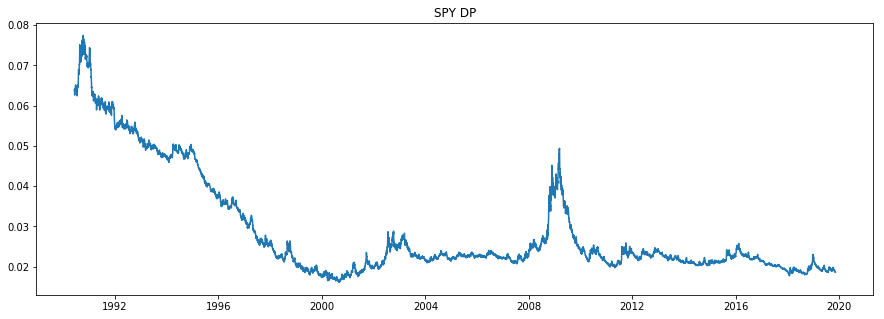

In [138]:
plt.figure(figsize=(15,5))
plt.plot(df_DP['date'],df_DP['DP'])
plt.title('SPY DP')
plt.show()

In [139]:
df_DP.describe()

,DP
count,7411.000000
mean,0.028813
std,0.012991
min,0.016077
25%,0.021033
50%,0.022776
75%,0.032026
max,0.077439


# PE: last earnings / price

In [140]:
# use beautifoulsoup to parse the website

URL = 'https://www.multpl.com/s-p-500-earnings/table/by-month'
r = requests.get(URL) 
soup = BeautifulSoup(r.content, 'html5lib') 

# gather dates
dates = [date.text for date in soup.find_all('td', attrs = {'class':'left'})]

# gather values
E = [val.text.split('\n')[0] for val in soup.find_all('td', attrs = {'class':'right'})]

df_E = pd.DataFrame()
df_E['date']=dates
df_E['date'] = df_E['date'].transform(lambda x: datetime.strptime(x,'%b %d, %Y').date())
df_E['E']=E

df_E = df_E.iloc[::-1]
df_E.reset_index(drop=True,inplace=True)

# now extend to daily frequency
df_PE = pd.DataFrame()
df_PE['date']=all_dates
PE_daily = []
i=1
lv = 0
for date in all_dates:
    nb = int(100*i/len(all_dates))
    if(nb%10 == 0) and (nb>0) and(nb>lv):
        lv = nb
        print(nb)
    price = float(SP500.iloc[SP500['Date'].tolist().index(date),1])
    #earnings = float(find_last_value(df_E,date))
    earnings = np.sum(find_last_x_values(df_E,date,12))/12
    PE_daily.append(price/earnings)
    i+=1
df_PE['PE'] = PE_daily

# save data
df_PE.to_pickle("./PE.pkl")

10
20
30
40
50
60
70
80
90
100


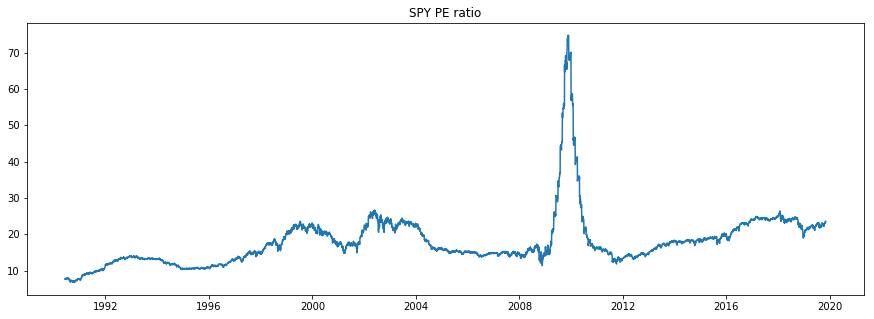

In [141]:
plt.figure(figsize=(15,5))
plt.plot(df_PE['date'],df_PE['PE'])
plt.title('SPY PE ratio')
plt.show()

In [142]:
df_PE.describe()

,PE
count,7411.000000
mean,17.911112
std,7.743070
min,6.717672
25%,13.699484
50%,16.318773
75%,21.454545
max,74.747953


# BM, book-to-market also known as book-to-price = 1/price-to-book

# BM: last book value / price

In [143]:
# use beautifoulsoup to parse the website

#URL = 'https://www.multpl.com/s-p-500-price-to-book/table/by-quarter'
URL = 'https://www.multpl.com/s-p-500-book-value/table/by-quarter'
r = requests.get(URL) 
soup = BeautifulSoup(r.content, 'html5lib') 

# gather dates
dates = [date.text for date in soup.find_all('td', attrs = {'class':'left'})]

# gather values
BV = [val.text[:6].split('\n')[0] for val in soup.find_all('td', attrs = {'class':'right'})]

df_BV = pd.DataFrame()
df_BV['date']=dates
df_BV['date'] = df_BV['date'].transform(lambda x: datetime.strptime(x,'%b %d, %Y').date())
df_BV['BV']=BV

df_BV = df_BV.iloc[::-1]
df_E.reset_index(drop=True,inplace=True)

# now extend to daily frequency
df_BM = pd.DataFrame()
df_BM['date']=all_dates[2417:]   # available only since 1999 31st december
BM_daily = []
for date in all_dates[2417:]:
    price = float(SP500.iloc[SP500['Date'].tolist().index(date),1])
    bookvalue = float(find_last_value(df_BV,date))
    BM_daily.append(bookvalue/price)
df_BM['BM'] = BM_daily

# save data
df_BM.to_pickle("./BM.pkl")

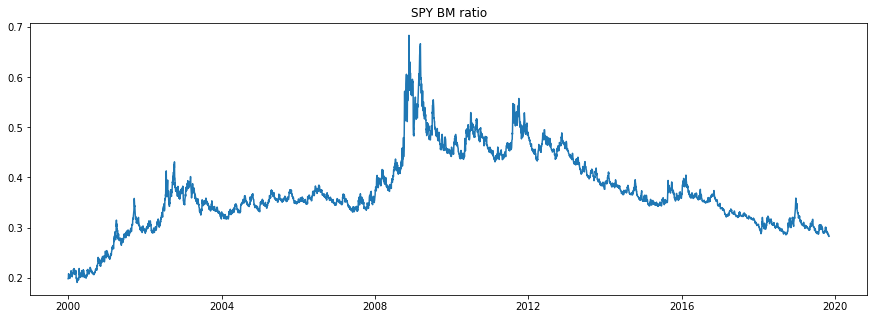

In [144]:
plt.figure(figsize=(15,5))
plt.plot(df_BM['date'],df_BM['BM'])
plt.title('SPY BM ratio')
plt.show()

In [145]:
df_BM.describe()

,BM
count,4994.000000
mean,0.370265
std,0.075923
min,0.190303
25%,0.325579
50%,0.357566
75%,0.413993
max,0.683908


# CAPE: price / average 10 years of earnings 

In [146]:
# use beautifoulsoup to parse the website

URL = 'https://www.multpl.com/s-p-500-earnings/table/by-year'
r = requests.get(URL) 
soup = BeautifulSoup(r.content, 'html5lib') 

# gather dates
dates = [date.text for date in soup.find_all('td', attrs = {'class':'left'})]

# gather values
EY = [float(val.text[:7].split('\n')[0]) for val in soup.find_all('td', attrs = {'class':'right'})]

df_EY = pd.DataFrame()
df_EY['date']=dates
df_EY['date'] = df_EY['date'].transform(lambda x: datetime.strptime(x,'%b %d, %Y').date())
df_EY['EY']=EY

df_EY = df_EY.iloc[::-1]
df_EY.reset_index(drop=True,inplace=True)

# now extend to daily frequency
df_CAPE = pd.DataFrame()
df_CAPE['date']=all_dates  
CAPE = []
for date in all_dates:
    price = float(SP500.iloc[SP500['Date'].tolist().index(date),1])
    earnings = avg_10_last_values(df_EY,date)
    CAPE.append(price/earnings)
df_CAPE['CAPE'] = CAPE

# save data
df_CAPE.to_pickle("./CAPE.pkl")

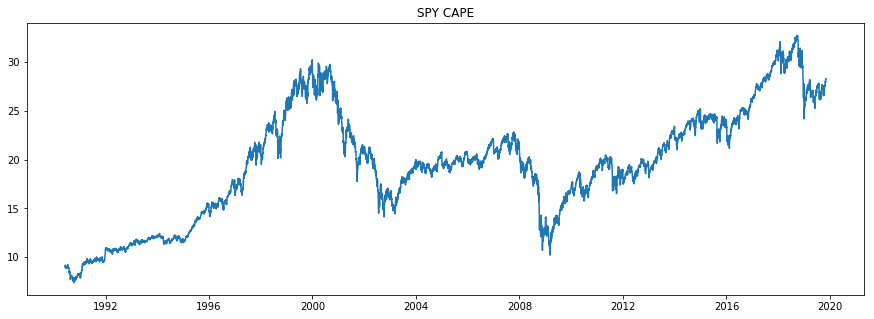

In [147]:
plt.figure(figsize=(15,5))
plt.plot(df_CAPE['date'],df_CAPE['CAPE'])
plt.title('SPY CAPE')
plt.show()

In [148]:
df_CAPE.describe()

,CAPE
count,7411.000000
mean,19.544043
std,5.717666
min,7.401302
25%,15.716449
50%,19.640181
75%,23.506607
max,32.726065


# BY 
### 10-year Treasury bond yield divided by the bond yield 12 months EMA

In [149]:
def ema(data, window):
    if len(data) < 2 * window:
        raise ValueError("data is too short")
    c = 2.0 / (window + 1)
    current_ema = sma(data[-window*2:-window], window)
    for value in data[-window:]:
        current_ema = (c * value) + ((1 - c) * current_ema)
    return current_ema


df_BY = pd.read_csv('FRED-DGS10.csv')
df_BY = df_BY.iloc[::-1]
df_BY.reset_index(drop=True,inplace=True)
df_BY['Date'] = df_BY['Date'].transform(lambda x: datetime.strptime(x,'%Y-%m-%d').date())

# now extend to daily frequency
df_BY2 = pd.DataFrame()
df_BY2['date']=all_dates  
BY2 = []
for date in all_dates:
    #price = float(SP500.iloc[SP500['Date'].tolist().index(date),1])
    #earnings = find_last_value(df_BY,date)
    #BY2.append(price/earnings)
    BY2.append(find_last_value(df_BY,date))
df_BY2['BY_wo_ema'] = BY2

# now compute BY/EMA

df_BY2['EMA'] = df_BY2['BY_wo_ema'].ewm(span=252).mean() # 252 trading days in a year, exponential weighted average
df_BY2['BY'] = [BY/(EMA) for BY,EMA in zip(df_BY2['BY_wo_ema'].tolist(),df_BY2['EMA'].tolist())]
df_BY2.drop(columns=['EMA','BY_wo_ema'],inplace=True)

# save data
df_BY2.to_pickle("./BY.pkl")

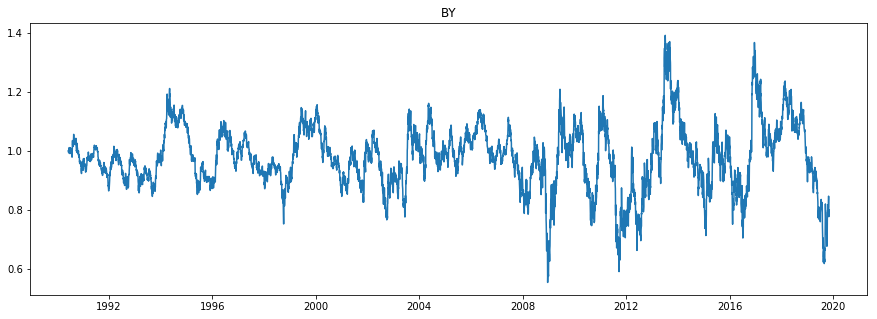

In [150]:
plt.figure(figsize=(15,5))
plt.plot(df_BY2['date'],df_BY2['BY'])
plt.title('BY')
plt.show()

In [151]:
df_BY2.describe()

,BY
count,7411.000000
mean,0.976956
std,0.108153
min,0.553318
25%,0.913521
50%,0.976078
75%,1.044952
max,1.391934


# DEF: (BAA-10Y Treasury)-(AAA-10Y Treasury)

In [152]:
df_baa = pd.read_csv('FRED-BAA10YM.csv')
df_aaa = pd.read_csv('FRED-AAA10YM.csv')
df_baa = df_baa.iloc[::-1]
df_baa.reset_index(drop=True,inplace=True)
df_aaa = df_aaa.iloc[::-1]
df_aaa.reset_index(drop=True,inplace=True)

df_baa['diff'] = df_baa['Value']-df_aaa['Value']
df_baa.drop(columns=['Value'],inplace=True)
df_baa['Date'] = df_baa['Date'].transform(lambda x: datetime.strptime(x,'%Y-%m-%d').date())

# now extend to daily frequency

df_DEF = pd.DataFrame()
df_DEF['date']=all_dates
DEF = []
for date in all_dates:
    DEF.append(find_last_value(df_baa,date))
    
df_DEF['DEF'] = DEF

# save data
df_DEF.to_pickle("./DEF.pkl")

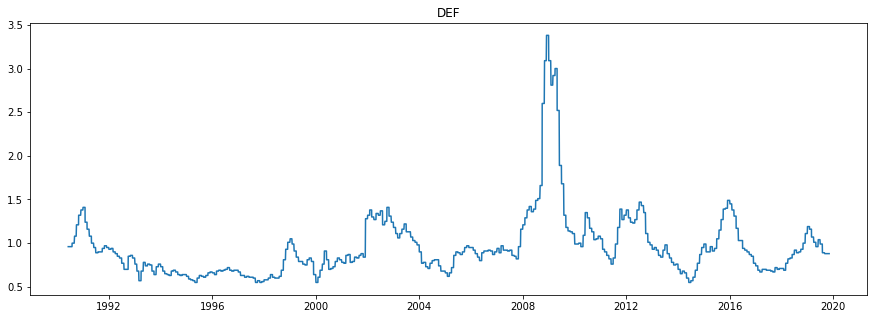

In [153]:
plt.figure(figsize=(15,5))
plt.plot(df_DEF['date'],df_DEF['DEF'])
plt.title('DEF')
plt.show()

In [154]:
df_DEF.describe()

,DEF
count,7411.000000
mean,0.952824
std,0.387848
min,0.550000
25%,0.700000
50%,0.880000
75%,1.050000
max,3.380000


In [157]:
# DP, PE, BM, CAPE, BY, DEF
stats = pd.DataFrame()
stats['DP'] = df_DP['DP']
stats['PE'] = df_PE['PE']
stats['BM'] = df_BM['BM']
stats['CAPE'] = df_CAPE['CAPE']
stats['BY'] = df_BY2['BY']
stats['DEF'] = df_DEF['DEF']

# save data
stats.to_pickle("./stats6.pkl")

# describe
stats.describe().T

,count,mean,std,min,25%,50%,75%,max
DP,7411.0,0.028813,0.012991,0.016077,0.021033,0.022776,0.032026,0.077439
PE,7411.0,17.911112,7.743070,6.717672,13.699484,16.318773,21.454545,74.747953
BM,4994.0,0.370265,0.075923,0.190303,0.325579,0.357566,0.413993,0.683908
CAPE,7411.0,19.544043,5.717666,7.401302,15.716449,19.640181,23.506607,32.726065
BY,7411.0,0.976956,0.108153,0.553318,0.913521,0.976078,1.044952,1.391934
DEF,7411.0,0.952824,0.387848,0.550000,0.700000,0.880000,1.050000,3.380000


# PCA price

In [40]:
# add 0 in the beginning for feature BM
stats = pd.read_pickle("./stats6.pkl")
bm = [0 for i in range(7411-4994)]
for el in stats['BM'][:4994]:
    bm.append(el)
stats['BM']=bm

# add dates
d = pd.read_pickle("./DEF.pkl")
d = d['date']
stats['date'] = d

# set date as index
stats.set_index('date',inplace=True,drop=True)

FileNotFoundError: [Errno 2] No such file or directory: './stats6.pkl'

In [48]:
# select features used in PCA
features = ['DP','PE','BM','CAPE']
# separating out the features
x = stats[features]
# standardizing the features
x = StandardScaler().fit_transform(x)
# proceed to PCA
pca = PCA(n_components=1)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents,columns = ['PCA Price'])

stats['PCA Price'] = principalDf['PCA Price'].tolist()

# save data
stats.to_pickle("./stats7.pkl")

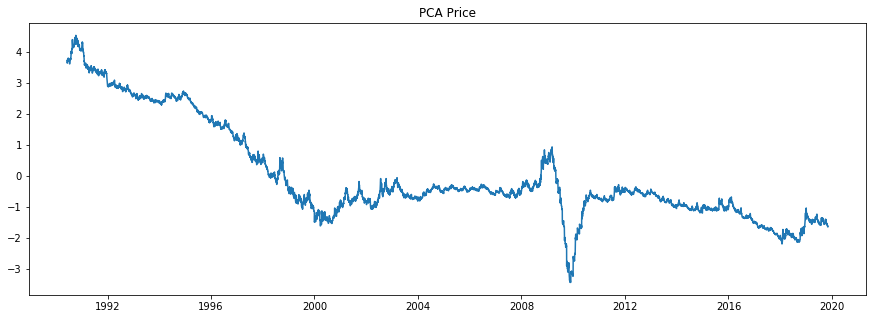

In [49]:
plt.figure(figsize=(15,5))
plt.plot(stats.index,principalDf['PCA Price'])
plt.title('PCA Price')
plt.show()

# Open all data

In [51]:
stats = pd.read_pickle('./stats7.pkl')

# Correlation Screening Regression

$R^{e}_{m,t \rightarrow t+130} = \alpha_{CS} + \beta'_{CS}\tilde{x}_{t} + \epsilon_{CS,t \rightarrow t+130}$

$\tilde{x}_{t} = \begin{pmatrix}  x_{1,t}I_{|\rho_{1,m}|>0.1}\\ 
x_{2,t}I_{|\rho_{2,m}|>0.1} \\
...\\
x_{16,t}I_{|\rho_{16,m}|>0.1}
\end{pmatrix}$

Every 20 days, we fit $y=X\beta + \epsilon$ with $X$

In [205]:
class CorrScreenRegressions:
    def __init__(self):
        pass
    def fit(self,X,y):
        X = X.T
        # screen variables: measure pairwise correlation between X(t) and y(t+130)
        R_130 = [y[i:i+130].sum() for i in range(X.shape[1]-130)]
        screened_ft = [i for i in range(X.shape[0]) if abs(np.corrcoef(np.array([X[i,:-130],R_130]))[0,1])>10/100]
        self.screened_ft = screened_ft
        #screened_ft = [i for i in range(X.shape[0]) if abs(np.corrcoef(np.array([X[i,:-130],y[130:]]))[0,1])>10/100]
        #print('screened_ft:',screened_ft)
        # fit parameters
        
        #self.reg = LinearRegression().fit(X.T, y)
        self.reg = LinearRegression().fit(X[screened_ft,:].T, y)
        
        #print('reg.coef_:',self.reg.coef_)
        #print('reg.intercept_:',self.reg.intercept_)
        #print('reg.score():',self.reg.score(X[screened_ft,:].T,y))
        
    def predict(self,X):
        X = X.T
        #return self.reg.predict(X.T)
        return self.reg.predict(X[self.screened_ft,:].T)

In [129]:
from scipy.linalg import cholesky

# Correlation matrix
corr_mat= np.array([[1.0, 0.6, 0.3],
                    [0.6, 1.0, 0.5],
                    [0.3, 0.5, 1.0]])

# Compute the (upper) Cholesky decomposition matrix
upper_chol = cholesky(corr_mat)

# Generate 3 series of normally distributed (Gaussian) numbers
rnd = np.random.normal(0.0, 1.0, size=(10*252, 3))

# Finally, compute the inner product of upper_chol and rnd
ans = (rnd @ upper_chol).T

y = np.random.normal(size=130).tolist()
for el in ans[0,:-130]:
    y.append(el)
y = np.array(y)
X = np.array([ans[1,:],
              ans[2,:],
              np.random.normal(size=2520),
              np.random.normal(size=2520)])

In [130]:
X.shape,y.shape

((4, 2520), (2520,))

In [131]:
CSR = CorrScreenRegressions()
CSR.fit(X,y)

screened_ft: [0, 1]
reg.coef_: [-0.04442896  0.03149589]
reg.intercept_: -0.009783536850067519


In [121]:
y = np.random.normal(size=10*252)
z = [y[i:i+130].sum() for i in range(10*252-130)]

# Test of CSR with the first 6 features

In [171]:
stats = pd.read_pickle('./stats7.pkl')
X = np.array(stats.iloc[1:2520,:])
#SP500.set_index('Date',drop=True,inplace=True)
y = SP500.loc[datetime.strptime('1990-06-08','%Y-%m-%d').date():datetime.strptime('2000-05-27','%Y-%m-%d').date()]['Adj Close']
y = np.array(y.pct_change()[1:].tolist())

X.shape,y.shape

((2519, 7), (2519,))

In [172]:
CSR = CorrScreenRegressions()
CSR.fit(X,y)

screened_ft: [0, 3, 6]
reg.coef_: [-0.11549636  0.00034093  0.00241825]
reg.intercept_: -0.004247085962965802
reg.score(): 0.00197271615236283


/Users/Karl/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/Karl/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


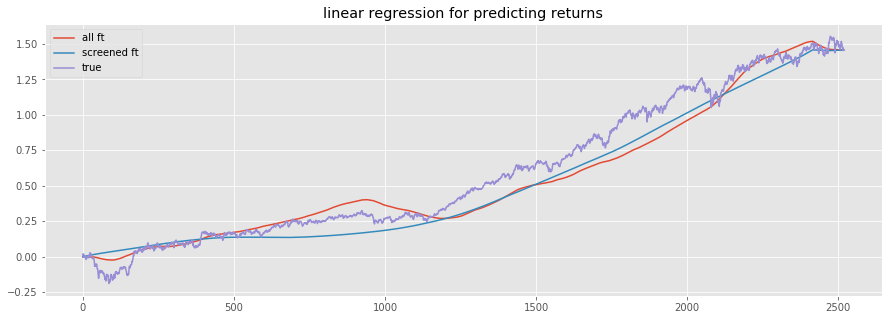

In [169]:
# test the fit 

testreg2 = LinearRegression().fit(X[[0,3,6],:].T, y)
testp2 = testreg2.predict(X[[0,3,6],:].T)

testreg = LinearRegression().fit(X.T, y)
testp = testreg.predict(X.T)

plt.figure(figsize=(15,5))
plt.plot(np.cumsum(testp),label='all ft')
plt.plot(np.cumsum(testp2),label='screened ft')
plt.plot(np.cumsum(y),label='true')
plt.title('linear regression for predicting returns')
plt.legend()
plt.show()

In [209]:
def corr_screen_prediction(nb_periods):
    
    p = []
    
    y_all = SP500.loc[datetime.strptime('1990-06-07','%Y-%m-%d').date():]['Adj Close']
    y_all = np.array(y_all.pct_change()[1:].tolist())
    X_all = np.array(stats)
    
    
    for t in range(nb_periods):
        
        #X = X_all[(1+20*t):(2520+20*t),:]
        #next_X = X_all[(2520+20*t):(2540+20*t),:]
        #y = y_all[(1+20*t):(2520+20*t)]
        
        X = X_all[20*t:(2520+20*t),:]
        next_X = X_all[(2520+20*t):(2540+20*t),:]
        y = y_all[20*t:(2520+20*t)]
        
        CSR = CorrScreenRegressions()
        CSR.fit(X,y)
        
        for el in CSR.predict(next_X):
            p.append(el)
        
    return p,y_all[2520:(2540+20*nb_periods)]

In [235]:
def corr_screen_fitcheck(nb_periods):
    
    f = []
    scores = []
    
    y_all = SP500.loc[datetime.strptime('1990-06-07','%Y-%m-%d').date():]['Adj Close']
    y_all = np.array(y_all.pct_change()[1:].tolist())
    X_all = np.array(stats)
    
    X = X_all[:2520,:]
    y = y_all[:2520]
        
    CSR = CorrScreenRegressions()
    CSR.fit(X,y)
    
    for el in CSR.predict(X):
        f.append(el)
    
    
    for t in range(1,nb_periods):
        
        X = X_all[20*t:(2520+20*t),:]
        y = y_all[20*t:(2520+20*t)]
        
        CSR = CorrScreenRegressions()
        CSR.fit(X,y)
        
        for el in CSR.predict(X)[-20:]:
            f.append(el)
        
    return f,y_all[:(2520+20*nb_periods)]

/Users/Karl/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/Karl/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/Karl/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/Karl/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


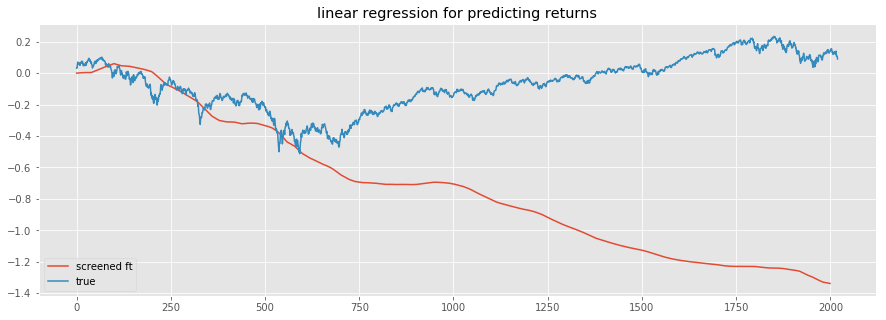

In [221]:
# test predictions

p,ytrue = corr_screen_prediction(100)


plt.figure(figsize=(15,5))
plt.plot(np.cumsum(p),label='screened ft')
plt.plot(np.cumsum(ytrue),label='true')
plt.title('linear regression for predicting returns')
plt.legend()
plt.show()

/Users/Karl/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/Karl/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/Karl/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/Karl/anaconda/envs/py36/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


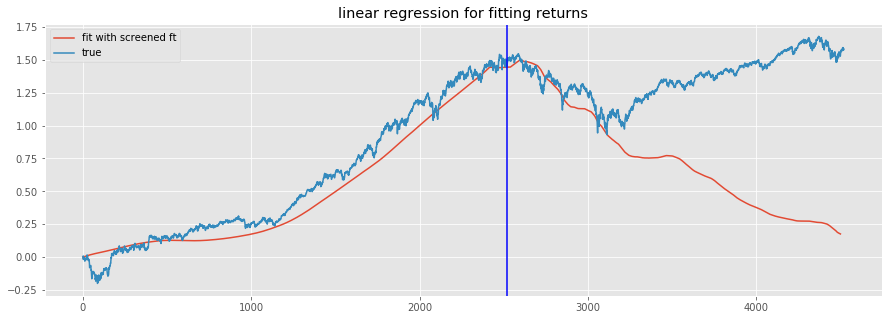

In [236]:
# test fit

f,ytrue = corr_screen_fitcheck(100)


plt.figure(figsize=(15,5))
plt.plot(np.cumsum(f),label='fit with screened ft')
plt.plot(np.cumsum(ytrue),label='true')
plt.axvline(x=2520,color='b')
plt.title('linear regression for fitting returns')
plt.legend()
plt.show()